In [1]:
# AGDS - Twitter

import networkx as nx
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from tqdm import tqdm
from collections import OrderedDict
from itertools import combinations
import math

def filter_tokens(tokens):
    tokens1 = []
    for token in tokens:
        if (token not in [".",",",";","&","'s", ":", "?", "!","(",")",\
            "'","'m","'no","***","--","...","[","]", " "]):
            tokens1.append(token)
    return tokens1

def fcn_stub(stub):
    return stub

def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns)
    cols = [str(w) for w in cols]
    
    for w1, w2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word

def nCr(n,r):
    f = math.factorial
    return int(f(n)/(f(r)*f(n-r)))

In [2]:
# Read .csv with processed tweets
with open('twitter_database.csv', "r") as f:
    df = pd.read_csv(f, index_col=0)
    
# Show head of DataFrame
df.head()

,_id,tweet_text,username,created_at,timestamp,archetype,processed_tweet
0,5f9f1c36b38e10f823bf2cef,"@eliostruyf So exciting, have fun! 😊",LEGO_Group,2020-10-30 18:23:50.000,NaN,artist,['excit']
1,5f9f1c36b38e10f823bf2ce7,These Brick-O-Lanterns are certainly all treat...,LEGO_Group,2020-10-31 09:00:28.000,NaN,artist,"['brick', 'lantern', 'certain', 'treat', 'tric..."
2,5f9f1c36b38e10f823bf2d0a,@dentistescabri Nous prenons la sécurité de no...,LEGO_Group,2020-10-30 12:07:58.000,NaN,artist,"['nous', 'prenon', 'curit', 'fan', 'rieux', 'p..."
3,5f9f1c36b38e10f823bf2cf5,@Jasmin80212446 😍🎄🥰,LEGO_Group,2020-10-30 16:35:39.000,NaN,artist,[]
4,5f9f1c36b38e10f823bf2d07,@ashleydrixey Sounds like a perfect fit for th...,LEGO_Group,2020-10-30 13:09:14.000,NaN,artist,"['sound', 'like', 'perfect', 'aspir', 'young',..."


In [3]:
# Replace string processed_tweet with list-like
df['processed_tweet'] = df['processed_tweet'].apply(lambda x: x.lstrip("[").rstrip("]").split(","))

# Drop tweets that have no words after processing
df = df.drop(df[df['processed_tweet'].map(len) < 2].index)

In [4]:
# Show dataframe head after processing
df.head()

# Extract 1000 tweets from each archetype
df = df.groupby('archetype').head(1000)

In [5]:
# Tokenize the words
df_ta = pd.DataFrame(columns=["processed_tweet", "archetype"])
for arch in df["archetype"].unique():
    dummy = pd.DataFrame(columns=["processed_tweet", "archetype"])
    dummy["processed_tweet"] = df[df["archetype"] == arch].groupby("archetype").apply(lambda x: (' '.join(str(txt) for txt in x["processed_tweet"])))
    dummy["archetype"] = arch
    df_ta = pd.concat([df_ta, dummy], ignore_index=True)

# Tokenize the dataframe
df_ta['processed_tweet'] = df_ta['processed_tweet'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: filter_tokens(x))

# Data vectorization
vectorizer = TfidfVectorizer(input="content", max_features=None, tokenizer=fcn_stub, preprocessor=fcn_stub)
vectorizer.fit(df_ta['processed_tweet'])
df_tfidf = vectorizer.transform(df_ta['processed_tweet'])
df_tfidf = df_tfidf.toarray()

# Get feature names
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)

df_tfidf = pd.DataFrame(df_tfidf, columns=vocab)
df_tfidf.head()

/home/maelstro/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,'','aah,'aarchi,'aaron,'aarzel,'aayush,'abandon,'abbey,'abbi,'abbiamo,...,'zulu,'zwei,'zyciora,``,gon,got,na,ta,wan,was
0,0.706564,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.706564,0.000265,0.000000,0.000443,0.000000,0.000292,0.000214
1,0.706169,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.706169,0.000000,0.000142,0.000097,0.000142,0.000127,0.000000
2,0.706256,0.0,0.000000,0.000310,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.706256,0.000678,0.000000,0.000568,0.000000,0.000000,0.000000
3,0.706619,0.0,0.000000,0.000116,0.0,0.0,0.000939,0.0,0.0,0.0,...,0.000206,0.0,0.0,0.706619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.706460,0.0,0.000178,0.000000,0.0,0.0,0.000135,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.706460,0.000110,0.000000,0.000092,0.000000,0.000000,0.000000


In [6]:
# Calculate PMI between words
names = vocab
name_idx = OrderedDict((name, 0) for name in names)
word_to_index = OrderedDict((name, index) for index, name in enumerate(names))

# Get the co-occurrences
occurrences = np.zeros((len(names), len(names)), dtype=np.int32)
windows_count = 0
window = 10             # Sliding window size, for calculation PMI between words 
for l in tqdm(df_ta['processed_tweet'], total=len(df_ta['processed_tweet'])):
    for i in range(len(l) - window):
        windows_count += 1
        d = set(l[i:(i+window)])
        for w in d:
            name_idx[w] += 1
        for w1, w2 in combinations(d, 2):
            i1 = word_to_index[w1]
            i2 = word_to_index[w2]
            
            occurrences[i1][i2] = 1
            occurrences[i2][i1] = 1
            
# Convert the occurences to PMI
pmi_per_word = pd.DataFrame(occurrences, index=names, columns=names) / windows_count
pmi_index = pd.Series(name_idx, index=name_idx.keys()) / windows_count

# Free memory
del occurrences
del name_idx

for col in tqdm(pmi_per_word.columns):
    pmi_per_word[col] = pmi_per_word[col]/pmi_index[col]

for row in tqdm(pmi_per_word.index):
    pmi_per_word.loc[row, :] = pmi_per_word.loc[row, :] / pmi_index[row]
    
pmi_per_word = pmi_per_word + 1E-9
for col in tqdm(pmi_per_word.columns):
    pmi_per_word[col] = pmi_per_word[col].apply(lambda x: math.log(x))

100%|██████████| 11199/11199 [00:37<00:00, 296.34it/s]


In [7]:
# Build a graph
graph = nx.Graph()
graph.add_nodes_from(df_tfidf.index)
graph.add_nodes_from(vocab)

# Build document-word edges
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in tqdm(df_tfidf.index, total=len(df_tfidf.index))\
                     for w in df_tfidf.columns]

word_word = word_word_edges(pmi_per_word)
graph.add_edges_from(document_word)
graph.add_edges_from(word_word)

100%|██████████| 62703201/62703201 [06:39<00:00, 156856.80it/s]


In [8]:
# Pickling current objects, in case of kernel crash
import pickle

def pickle_object(obj, file_name):
    with open(f'agds_nx/{file_name}.pickle', "wb") as f:
        pickle.dump(obj, f)

# Pickle graph, TF-IDF vectorizer and extracted DataFrame
pickle_object(graph, "graph")
pickle_object(df_tfidf, "df_tfidf")
pickle_object(vectorizer, "tfidf_vectorizer")

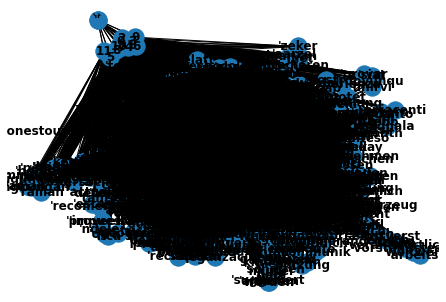

In [11]:
# Plot the graph
import matplotlib.pyplot as plt
nx.draw(graph, with_labels=True, font_weight='bold')
plt.show()